In [1]:
# import os
# !git clone -q https://github.com/NVIDIA/tacotron2
# os.chdir('tacotron2')
# !git submodule init
# !git submodule update
# !pip install -q unidecode tensorboardX

In [2]:
import os
files = "wavs"
count = 0
# Iterate directory
for path in os.listdir(files):
    # check if current path is a file
    if os.path.isfile(os.path.join(files, path)):
        count += 1
print('File count:', count)

File count: 604


In [3]:
# !pip install matplotlib
# !pip install torch

In [4]:
os.getcwd()

'G:\\Research\\TTA\\Tam-TTS\\tacotron2'

In [5]:
import torch
torch.cuda.is_available()

True

In [6]:
#@title Training Model

%matplotlib inline
import os
if os.getcwd() != 'G:\\Research\\TTA\\Tam-TTS\\tacotron2':
    os.chdir('tacotron2')
import time
import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

# import numba
# from numba.core.typing import cffi_utils as cffi_support

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
# from tqdm.notebook import tqdm # Modern Notebook TQDM
from tqdm import tqdm
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    hparams.sampling_rate = 48000
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate , hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    # print("####### ---------- >>>>> hparams.training_files: ", hparams.training_files)
    trainset = TextMelLoader(hparams.training_files, hparams)
    # print("####### ---------- >>>>> hparams.validation_files: ", hparams.validation_files)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    # print("checkpoint_dict : ", checkpoint_dict)
    model_dict = checkpoint_dict['state_dict']
    # print("Model DICT : ", model_dict)
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout
    
        output_directory:  outdir
        log_directory:  logs1
        checkpoint_path:  outdir/Tamil
        warm_start:  False
        n_gpus:  1
        rank:  0
        group_name:  None
    
    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)
    # print("####---->>> Train Loader: ", train_loader, " #####--->>> Valset: ", valset, " ### --->> collate_fn: ", collate_fn)
    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
        os.path.isfile("tacotron2_statedict.pt")
        model = warm_start_model("tacotron2_statedict.pt", model, hparams.ignore_layers)
        # print("########## MODEL ########", model)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        # print("######## ------>>>> TRAIN LOADER : ", train_loader)
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            # import pdb;pdb.set_trace()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            print(file[0])
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
# ---- Replace .wav with .npy in filelists ----

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
# model_filename = 'current_model'
model_filename = "Tamil"
hparams.training_files = "filelists\sample_train_data.txt"
hparams.validation_files = "filelists\sample_test_data.txt"
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 4 #32
hparams.load_mel_from_disk = False
hparams.ignore_layers = []
hparams.epochs = 300 #10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = 'G:\\Research\\TTA\\Tam-TTS\\tacotron2\\colab\\outdir' # Location to save Checkpoints
log_directory = 'G:\\Research\\TTA\\Tam-TTS\\tacotron2\\logs' # Location to save Log files locally
log_directory2 = 'G:\\Research\\TTA\\Tam-TTS\\tacotron2\\colab\\logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'sed' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# model_filename = "Tamil" #@param {type:"string"}

In [8]:
if generate_mels:
    create_mels()

Generating Mels


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [00:11<00:00, 26.39it/s]


In [9]:
check_dataset(hparams)

Checking Training Files
wavs/taf_02345_00348037167.wav
wavs/taf_07049_00155837462.wav
wavs/taf_09705_01218130267.wav
wavs/taf_03219_00712757493.wav
wavs/taf_00008_01305524612.wav
wavs/taf_04125_01507228128.wav
wavs/taf_07910_01584356993.wav
wavs/taf_07894_00517992937.wav
wavs/taf_04696_00523634279.wav
wavs/taf_05001_00531982185.wav
wavs/taf_01484_01055566125.wav
wavs/taf_02027_01350099461.wav
wavs/taf_02042_01490052249.wav
wavs/taf_02345_01664073518.wav
wavs/taf_02330_00096194830.wav
wavs/taf_09689_00036562162.wav
wavs/taf_06478_01490963620.wav
wavs/taf_02027_00150647812.wav
wavs/taf_02027_00554998467.wav
wavs/taf_02345_01052998033.wav
wavs/taf_02042_02042842418.wav
wavs/taf_06958_00360322187.wav
wavs/taf_04125_01909453453.wav
wavs/taf_03822_01234946154.wav
wavs/taf_03219_00279311328.wav
wavs/taf_07910_00205494685.wav
wavs/taf_07910_01902313674.wav
wavs/taf_08213_01061328793.wav
wavs/taf_06478_01863177583.wav
wavs/taf_06958_01781151721.wav
wavs/taf_07910_01119711285.wav
wavs/taf_06796_

In [10]:
torch.cuda.is_available()

True

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
output_directory:  G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir
log_directory:  G:\Research\TTA\Tam-TTS\tacotron2\logs
checkpoint_path:  G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
warm_start:  False
n_gpus:  1
rank:  0
group_name:  None
hparams:  epochs=300,iters_per_checkpoint=1000,seed=1234,dynamic_loss_scaling=True,fp16_run=False,distributed_run=False,dist_backend=nccl,dist_url=tcp://localhost:54321,cudnn_enabled=True,cudnn_benchmark=False,ignore_layers=[],load_mel_from_disk=False,training_files=filelists\sample_train_data.txt,validation_files=filelists\sample_test_data.txt,text_cleaners=['english_cleaners'],max_wav_value=32768.0,sampling_rate=48000,filter_length=1024,hop_length=256,win_length=1024,n_mel_channels=80,mel_fmin=0.0,mel_fmax=8000.0,n_symbols=148,symbols_embedding_dim=512,encoder_kernel_size=5,encoder_n_convolutions=3,encoder_embedding_dim=512,n_frames

  0%|                                                                                           | 0/44 [00:00<?, ?it/s]


Starting Epoch: 256 Iteration: 15362



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:02<00:00, 34.05s/it]


Epoch: 256 Validation loss 15422:  0.655039  Time: 36.1m LR: 0.000474


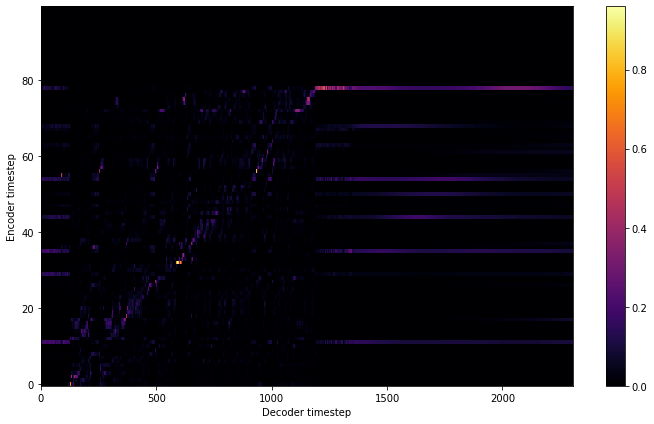

Saving model and optimizer state at iteration 15422 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


  2%|█▊                                                                            | 1/44 [36:15<25:58:54, 2175.23s/it]


Starting Epoch: 257 Iteration: 15422



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:20<00:00, 34.34s/it]


Epoch: 257 Validation loss 15482:  0.652291  Time: 36.2m LR: 0.000471


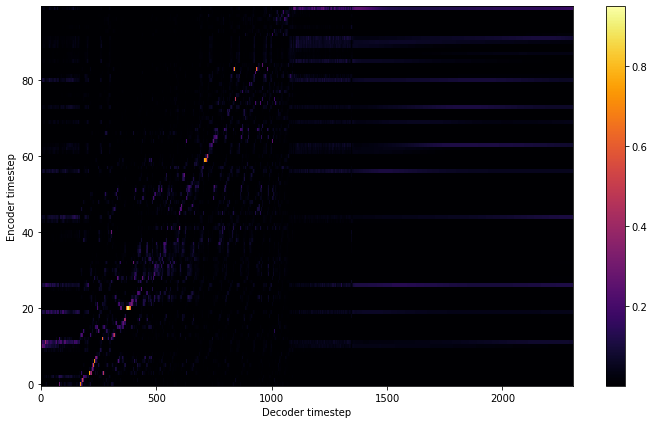

Saving model and optimizer state at iteration 15482 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


  5%|███▍                                                                        | 2/44 [1:12:28<25:21:58, 2174.25s/it]

Model Saved

Starting Epoch: 258 Iteration: 15482



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:34<00:00, 34.57s/it]


Epoch: 258 Validation loss 15542:  0.644540  Time: 36.4m LR: 0.000467


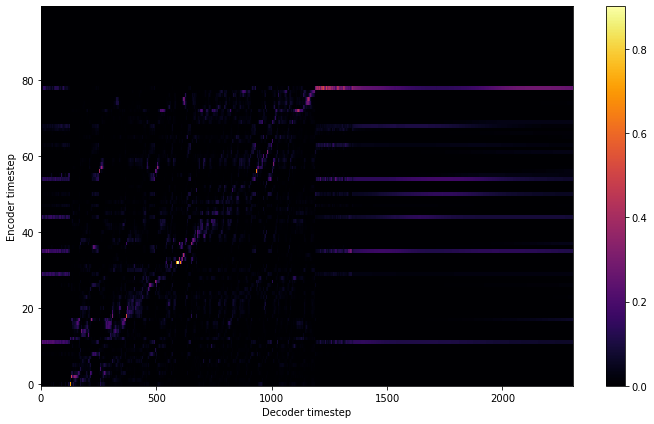

Saving model and optimizer state at iteration 15542 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


  7%|█████▏                                                                      | 3/44 [1:48:54<24:49:20, 2179.53s/it]

Model Saved

Starting Epoch: 259 Iteration: 15542



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [35:11<00:00, 35.19s/it]


Epoch: 259 Validation loss 15602:  0.663231  Time: 37.0m LR: 0.000464


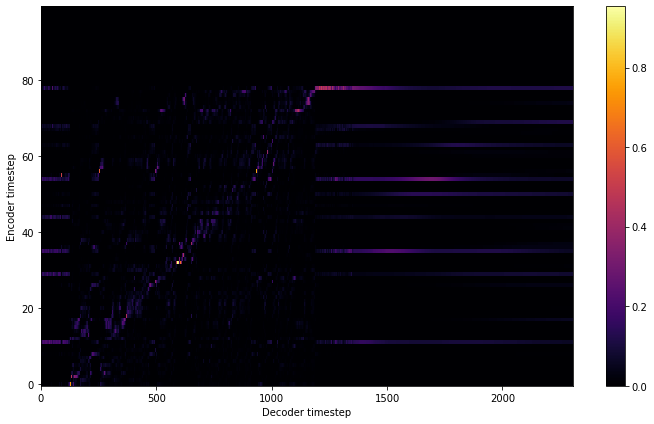

Saving model and optimizer state at iteration 15602 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


  9%|██████▉                                                                     | 4/44 [2:25:55<24:23:58, 2195.97s/it]

Model Saved

Starting Epoch: 260 Iteration: 15602



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:31<00:00, 34.53s/it]


Epoch: 260 Validation loss 15662:  0.644995  Time: 36.3m LR: 0.000460


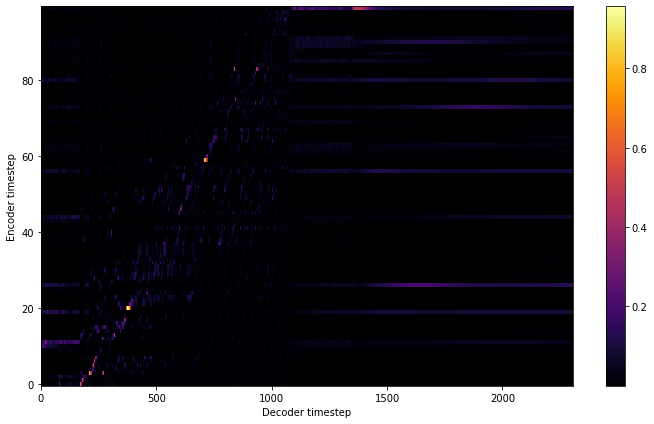

Saving model and optimizer state at iteration 15662 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 11%|████████▋                                                                   | 5/44 [3:02:18<23:44:14, 2191.15s/it]

Model Saved

Starting Epoch: 261 Iteration: 15662



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:27<00:00, 34.46s/it]


Epoch: 261 Validation loss 15722:  0.651876  Time: 36.3m LR: 0.000457


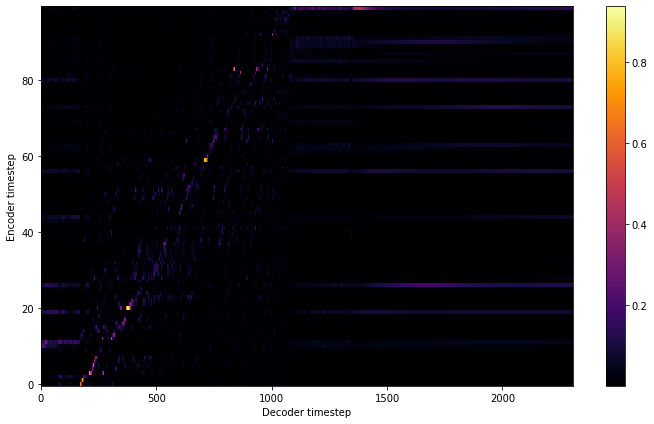

Saving model and optimizer state at iteration 15722 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 14%|██████████▎                                                                 | 6/44 [3:38:38<23:05:16, 2187.27s/it]

Model Saved

Starting Epoch: 262 Iteration: 15722



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:46<00:00, 34.77s/it]


Epoch: 262 Validation loss 15782:  0.655899  Time: 36.6m LR: 0.000453


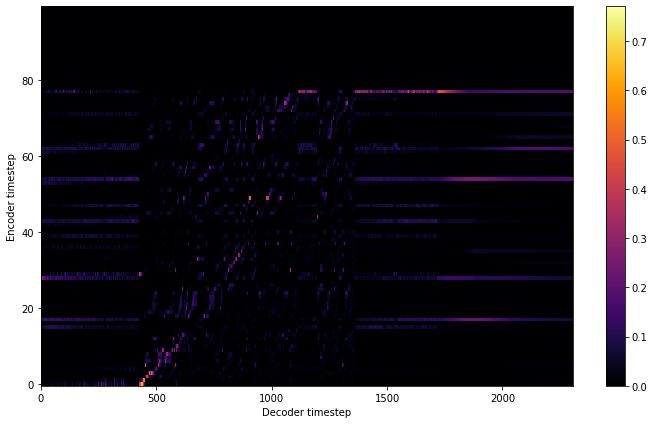

Saving model and optimizer state at iteration 15782 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 16%|████████████                                                                | 7/44 [4:15:15<22:30:48, 2190.50s/it]

Model Saved

Starting Epoch: 263 Iteration: 15782



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:02<00:00, 34.05s/it]


Epoch: 263 Validation loss 15842:  0.658921  Time: 35.9m LR: 0.000450


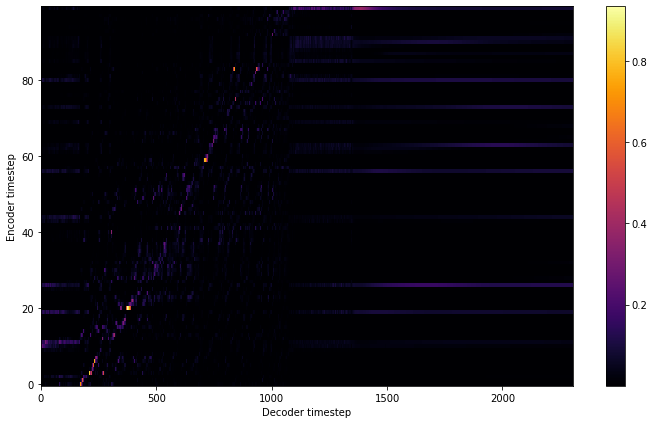

Saving model and optimizer state at iteration 15842 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 18%|█████████████▊                                                              | 8/44 [4:51:12<21:47:54, 2179.84s/it]

Model Saved

Starting Epoch: 264 Iteration: 15842



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:34<00:00, 34.57s/it]


Epoch: 264 Validation loss 15902:  0.653511  Time: 36.4m LR: 0.000447


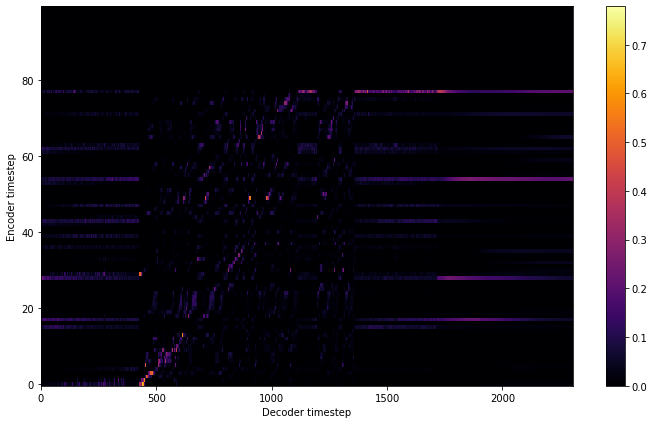

Saving model and optimizer state at iteration 15902 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 20%|███████████████▌                                                            | 9/44 [5:27:37<21:12:33, 2181.54s/it]

Model Saved

Starting Epoch: 265 Iteration: 15902



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [35:01<00:00, 35.02s/it]


Epoch: 265 Validation loss 15962:  0.654903  Time: 36.8m LR: 0.000443


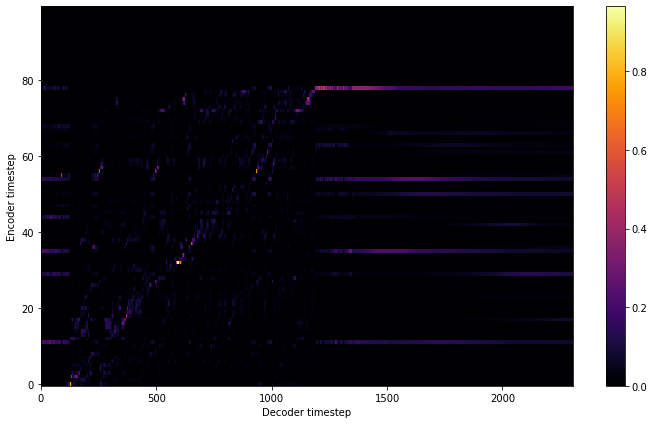

Saving model and optimizer state at iteration 15962 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 23%|█████████████████                                                          | 10/44 [6:04:29<20:41:30, 2190.90s/it]

Model Saved

Starting Epoch: 266 Iteration: 15962



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:13<00:00, 34.23s/it]


Epoch: 266 Validation loss 16022:  0.662665  Time: 36.0m LR: 0.000440


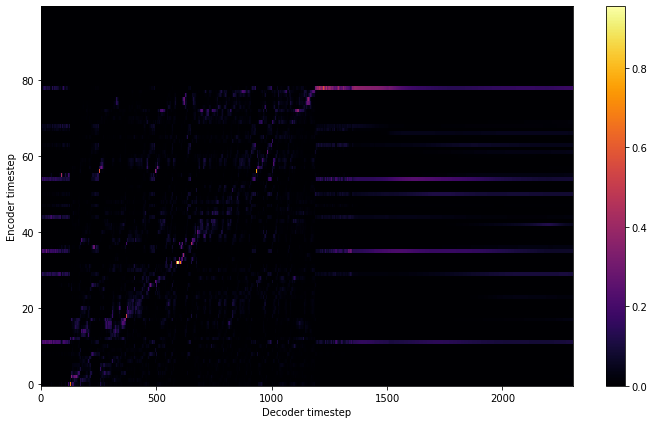

Saving model and optimizer state at iteration 16022 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 25%|██████████████████▊                                                        | 11/44 [6:40:33<20:00:33, 2182.82s/it]

Model Saved

Starting Epoch: 267 Iteration: 16022



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:05<00:00, 34.09s/it]


Epoch: 267 Validation loss 16082:  0.663248  Time: 35.9m LR: 0.000437


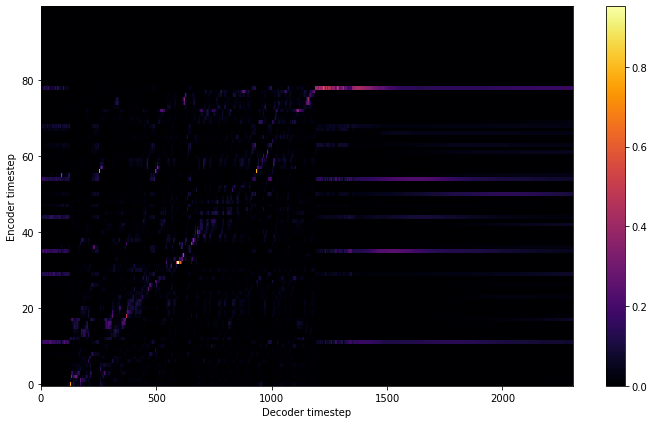

Saving model and optimizer state at iteration 16082 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 27%|████████████████████▍                                                      | 12/44 [7:16:31<19:20:07, 2175.24s/it]

Model Saved

Starting Epoch: 268 Iteration: 16082



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:49<00:00, 34.83s/it]


Epoch: 268 Validation loss 16142:  0.652885  Time: 36.6m LR: 0.000434


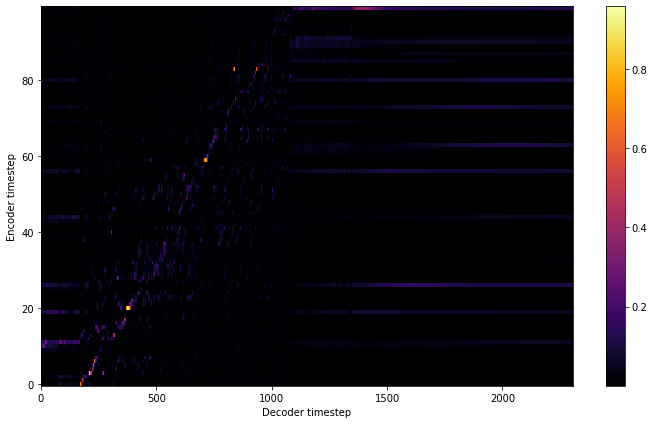

Saving model and optimizer state at iteration 16142 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 30%|██████████████████████▏                                                    | 13/44 [7:53:13<18:47:56, 2183.12s/it]

Model Saved

Starting Epoch: 269 Iteration: 16142



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:45<00:00, 34.76s/it]


Epoch: 269 Validation loss 16202:  0.663802  Time: 36.5m LR: 0.000430


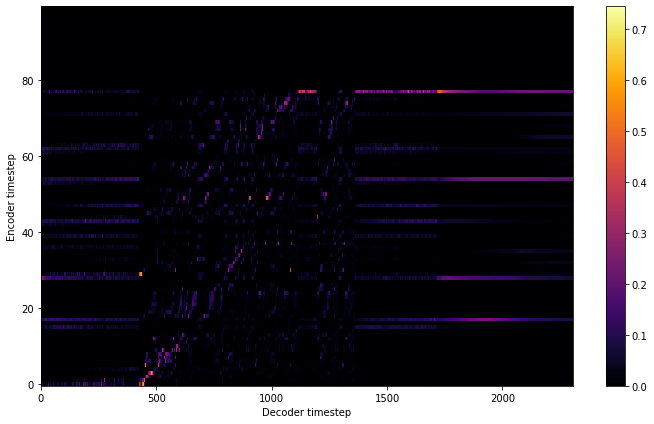

Saving model and optimizer state at iteration 16202 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 32%|███████████████████████▊                                                   | 14/44 [8:29:49<18:13:30, 2187.00s/it]

Model Saved

Starting Epoch: 270 Iteration: 16202



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:09<00:00, 34.16s/it]


Epoch: 270 Validation loss 16262:  0.658933  Time: 36.0m LR: 0.000427


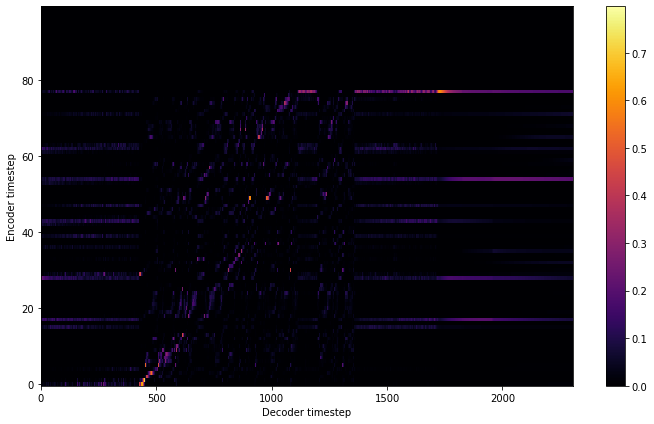

Saving model and optimizer state at iteration 16262 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 34%|█████████████████████████▌                                                 | 15/44 [9:05:49<17:33:10, 2178.97s/it]

Model Saved

Starting Epoch: 271 Iteration: 16262



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:06<00:00, 34.12s/it]


Epoch: 271 Validation loss 16322:  0.661165  Time: 35.9m LR: 0.000424


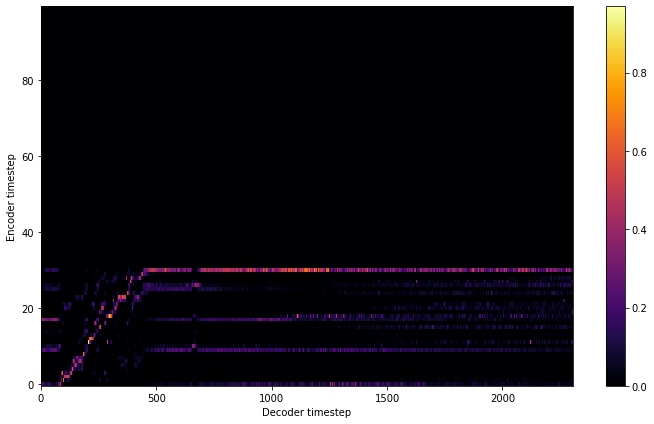

Saving model and optimizer state at iteration 16322 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 36%|███████████████████████████▎                                               | 16/44 [9:41:49<16:54:08, 2173.16s/it]

Model Saved

Starting Epoch: 272 Iteration: 16322



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:53<00:00, 34.89s/it]


Epoch: 272 Validation loss 16382:  0.661925  Time: 36.7m LR: 0.000421


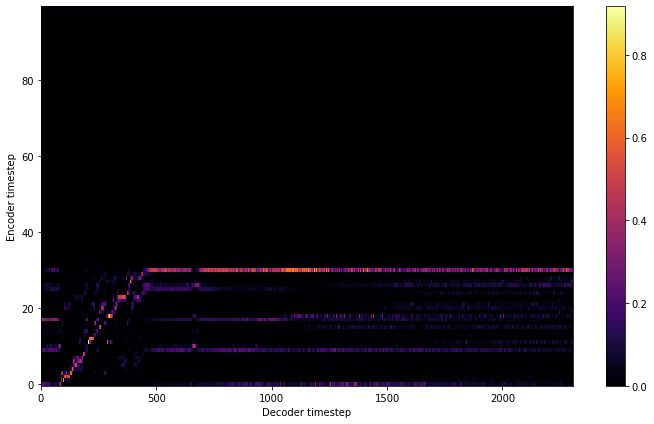

Saving model and optimizer state at iteration 16382 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 39%|████████████████████████████▌                                             | 17/44 [10:18:33<16:22:06, 2182.48s/it]

Model Saved

Starting Epoch: 273 Iteration: 16382



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:45<00:00, 34.75s/it]


Epoch: 273 Validation loss 16442:  0.663594  Time: 36.5m LR: 0.000418


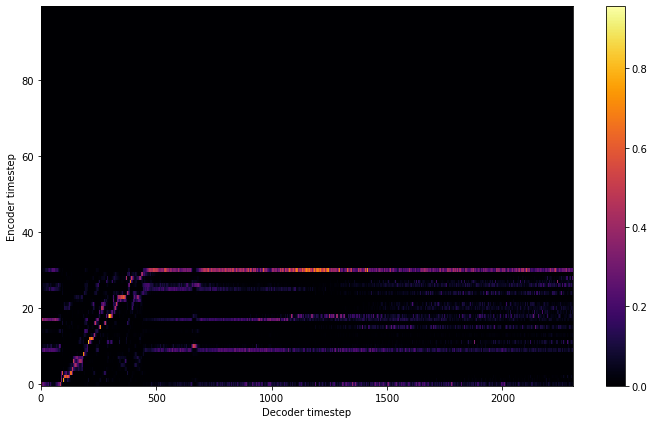

Saving model and optimizer state at iteration 16442 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 41%|██████████████████████████████▎                                           | 18/44 [10:55:09<15:47:29, 2186.53s/it]

Model Saved

Starting Epoch: 274 Iteration: 16442



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:16<00:00, 34.28s/it]


Epoch: 274 Validation loss 16502:  0.670144  Time: 36.1m LR: 0.000414


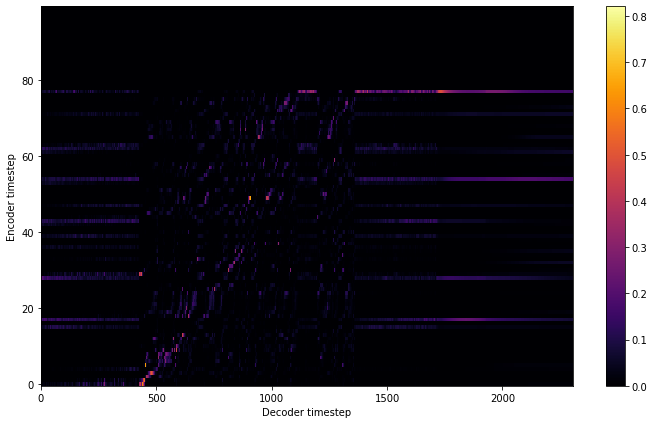

Saving model and optimizer state at iteration 16502 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 43%|███████████████████████████████▉                                          | 19/44 [11:31:17<15:08:42, 2180.92s/it]

Model Saved

Starting Epoch: 275 Iteration: 16502



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:09<00:00, 34.15s/it]


Epoch: 275 Validation loss 16562:  0.661610  Time: 35.9m LR: 0.000411


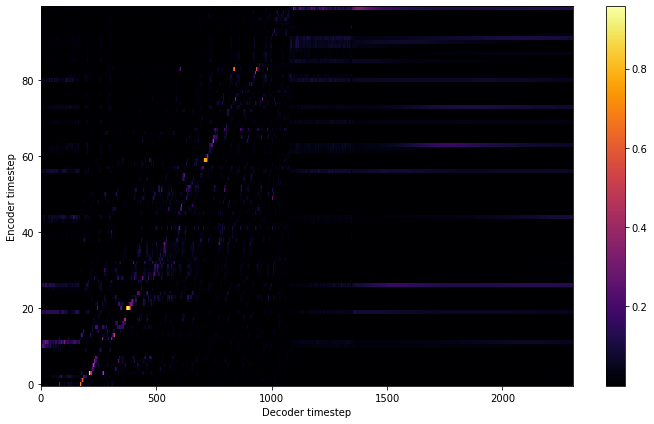

Saving model and optimizer state at iteration 16562 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 45%|█████████████████████████████████▋                                        | 20/44 [12:07:17<14:29:56, 2174.87s/it]

Model Saved

Starting Epoch: 276 Iteration: 16562



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:29<00:00, 34.49s/it]


Epoch: 276 Validation loss 16622:  0.661194  Time: 36.3m LR: 0.000408


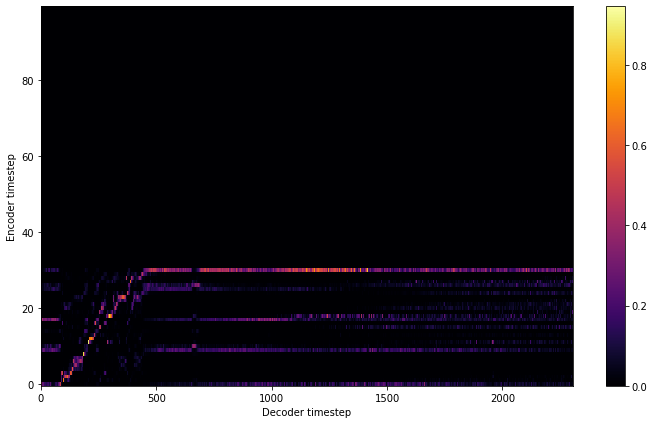

Saving model and optimizer state at iteration 16622 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 48%|███████████████████████████████████▎                                      | 21/44 [12:43:39<13:54:26, 2176.82s/it]

Model Saved

Starting Epoch: 277 Iteration: 16622



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:12<00:00, 34.21s/it]


Epoch: 277 Validation loss 16682:  0.662287  Time: 36.0m LR: 0.000405


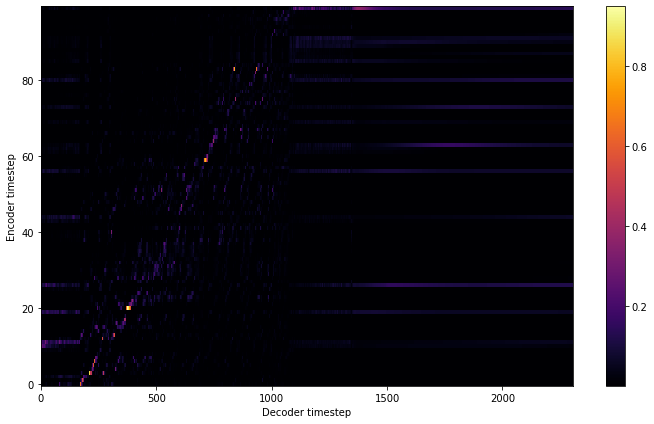

Saving model and optimizer state at iteration 16682 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 50%|█████████████████████████████████████                                     | 22/44 [13:19:44<13:16:52, 2173.31s/it]


Starting Epoch: 278 Iteration: 16682



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:03<00:00, 34.06s/it]


Epoch: 278 Validation loss 16742:  0.659611  Time: 35.9m LR: 0.000402


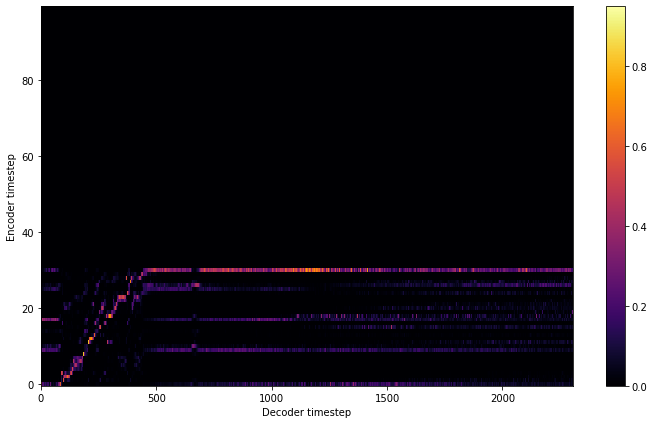

Saving model and optimizer state at iteration 16742 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 52%|██████████████████████████████████████▋                                   | 23/44 [13:55:40<12:38:52, 2168.22s/it]


Starting Epoch: 279 Iteration: 16742



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:29<00:00, 34.49s/it]


Epoch: 279 Validation loss 16802:  0.666239  Time: 36.3m LR: 0.000399


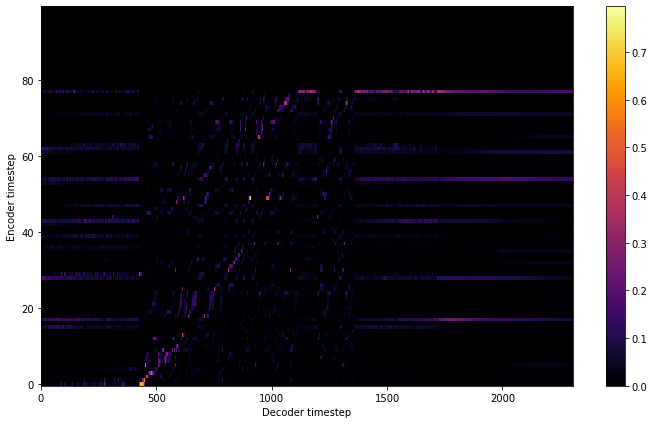

Saving model and optimizer state at iteration 16802 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 55%|████████████████████████████████████████▎                                 | 24/44 [14:32:01<12:03:59, 2171.96s/it]


Starting Epoch: 280 Iteration: 16802



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:40<00:00, 34.67s/it]


Epoch: 280 Validation loss 16862:  0.659286  Time: 36.4m LR: 0.000396


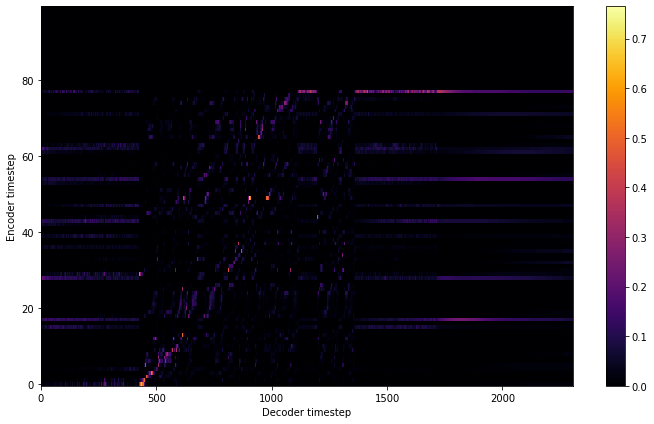

Saving model and optimizer state at iteration 16862 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 57%|██████████████████████████████████████████                                | 25/44 [15:08:31<11:29:29, 2177.36s/it]

Model Saved

Starting Epoch: 281 Iteration: 16862



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:04<00:00, 34.07s/it]


Epoch: 281 Validation loss 16922:  0.671294  Time: 35.9m LR: 0.000393


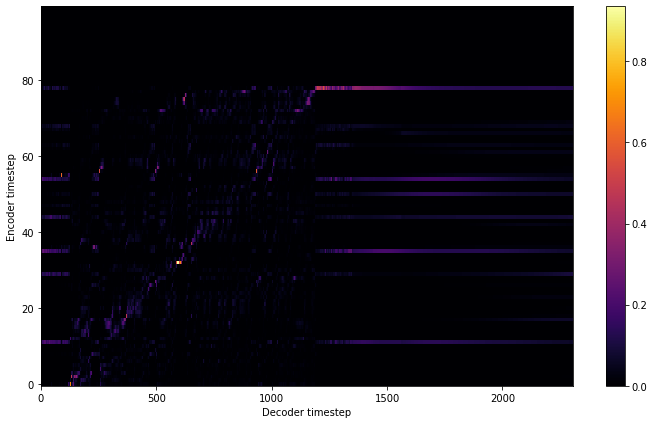

Saving model and optimizer state at iteration 16922 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 59%|███████████████████████████████████████████▋                              | 26/44 [15:44:31<10:51:38, 2172.14s/it]


Starting Epoch: 282 Iteration: 16922



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:29<00:00, 34.50s/it]


Epoch: 282 Validation loss 16982:  0.667836  Time: 36.4m LR: 0.000390


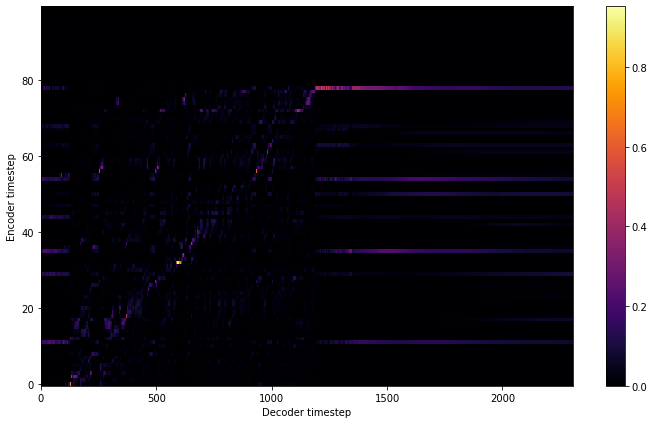

Saving model and optimizer state at iteration 16982 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 61%|█████████████████████████████████████████████▍                            | 27/44 [16:20:55<10:16:28, 2175.79s/it]


Starting Epoch: 283 Iteration: 16982



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:31<00:00, 34.53s/it]


Epoch: 283 Validation loss 17042:  0.675103  Time: 36.3m LR: 0.000387


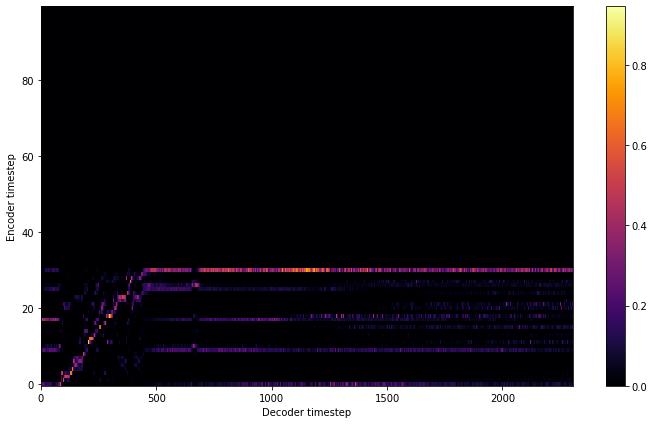

Saving model and optimizer state at iteration 17042 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 64%|███████████████████████████████████████████████▋                           | 28/44 [16:57:18<9:40:44, 2177.81s/it]


Starting Epoch: 284 Iteration: 17042



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:42<00:00, 34.71s/it]


Epoch: 284 Validation loss 17102:  0.668628  Time: 36.5m LR: 0.000385


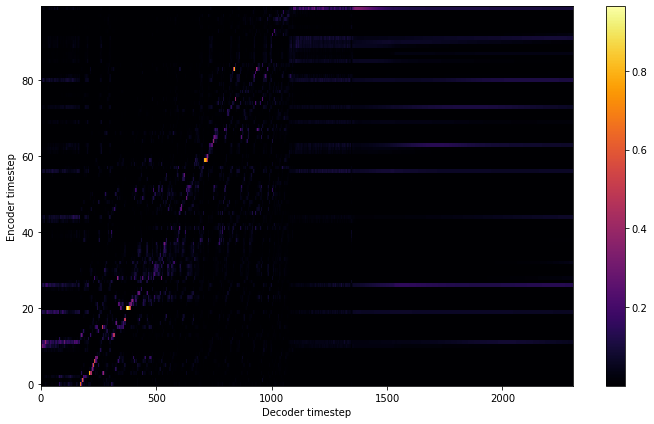

Saving model and optimizer state at iteration 17102 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil


 66%|█████████████████████████████████████████████████▍                         | 29/44 [17:33:53<9:05:46, 2183.08s/it]

Model Saved

Starting Epoch: 285 Iteration: 17102



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:13<00:00, 34.22s/it]


Epoch: 285 Validation loss 17162:  0.670352  Time: 36.0m LR: 0.000382


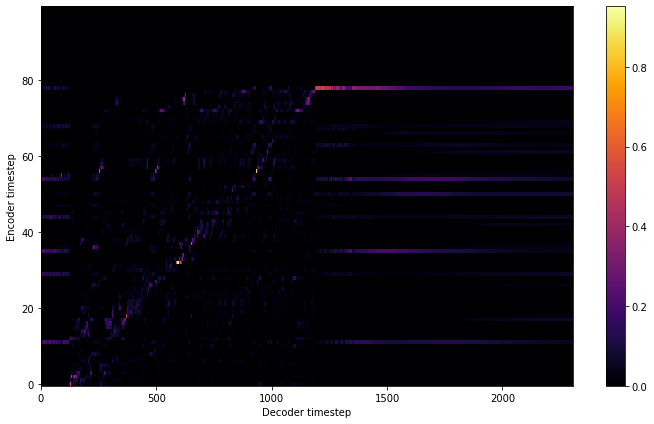

Saving model and optimizer state at iteration 17162 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 68%|███████████████████████████████████████████████████▏                       | 30/44 [18:09:57<8:28:03, 2177.41s/it]


Starting Epoch: 286 Iteration: 17162



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:22<00:00, 34.38s/it]


Epoch: 286 Validation loss 17222:  0.676369  Time: 36.2m LR: 0.000379


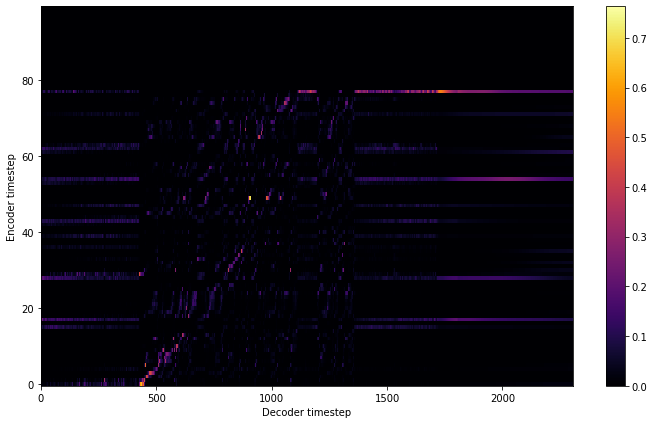

Saving model and optimizer state at iteration 17222 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 70%|████████████████████████████████████████████████████▊                      | 31/44 [18:46:11<7:51:33, 2176.41s/it]


Starting Epoch: 287 Iteration: 17222



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:50<00:00, 34.84s/it]


Epoch: 287 Validation loss 17282:  0.682776  Time: 36.6m LR: 0.000376


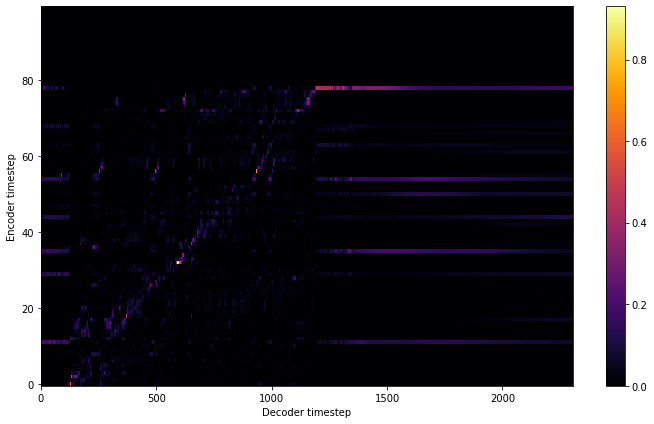

Saving model and optimizer state at iteration 17282 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 73%|██████████████████████████████████████████████████████▌                    | 32/44 [19:22:53<7:16:48, 2184.04s/it]


Starting Epoch: 288 Iteration: 17282



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [35:08<00:00, 35.14s/it]


Epoch: 288 Validation loss 17342:  0.673899  Time: 36.9m LR: 0.000373


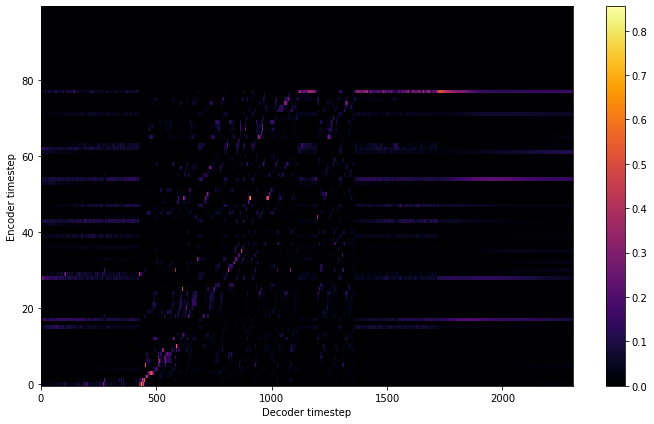

Saving model and optimizer state at iteration 17342 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 75%|████████████████████████████████████████████████████████▎                  | 33/44 [19:59:52<6:42:20, 2194.58s/it]


Starting Epoch: 289 Iteration: 17342



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:33<00:00, 34.56s/it]


Epoch: 289 Validation loss 17402:  0.669092  Time: 36.4m LR: 0.000370


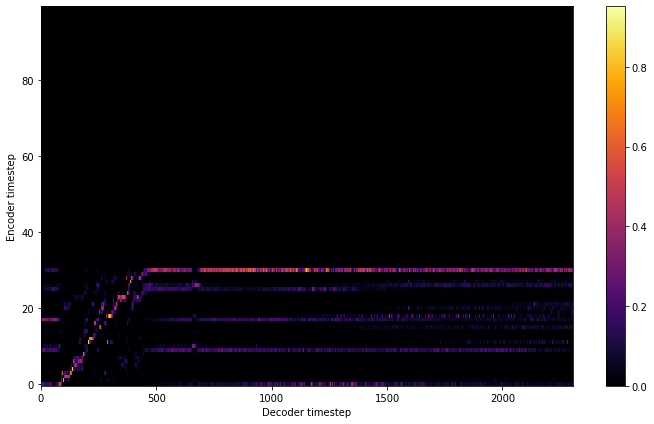

Saving model and optimizer state at iteration 17402 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 77%|█████████████████████████████████████████████████████████▉                 | 34/44 [20:36:17<6:05:15, 2191.55s/it]


Starting Epoch: 290 Iteration: 17402



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:38<00:00, 34.64s/it]


Epoch: 290 Validation loss 17462:  0.671830  Time: 36.4m LR: 0.000368


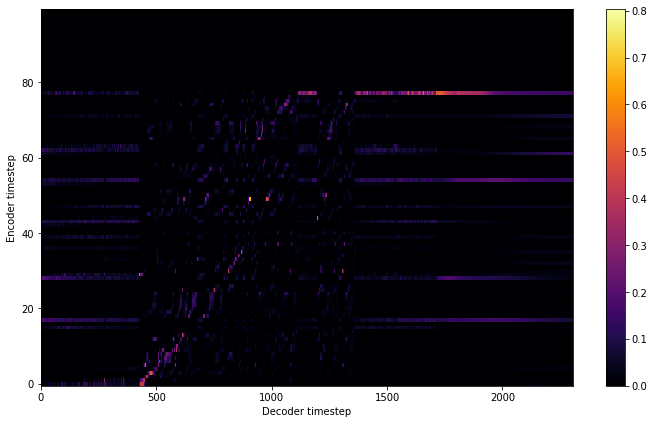

Saving model and optimizer state at iteration 17462 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 80%|███████████████████████████████████████████████████████████▋               | 35/44 [21:12:46<5:28:36, 2190.78s/it]


Starting Epoch: 291 Iteration: 17462



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [33:54<00:00, 33.91s/it]


Epoch: 291 Validation loss 17522:  0.672989  Time: 35.7m LR: 0.000365


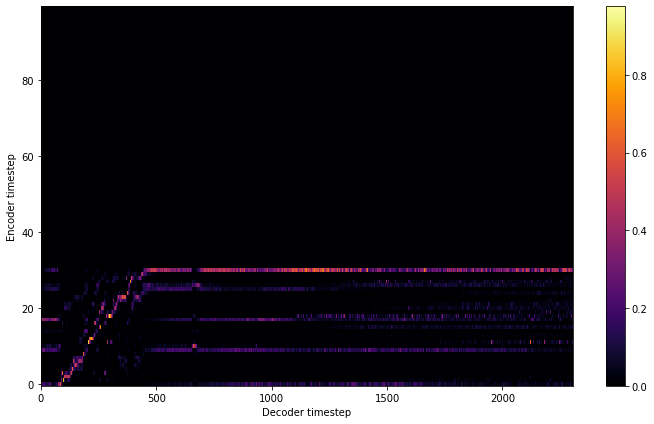

Saving model and optimizer state at iteration 17522 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 82%|█████████████████████████████████████████████████████████████▎             | 36/44 [21:48:30<4:50:14, 2176.83s/it]


Starting Epoch: 292 Iteration: 17522



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:18<00:00, 34.32s/it]


Epoch: 292 Validation loss 17582:  0.686974  Time: 36.1m LR: 0.000362


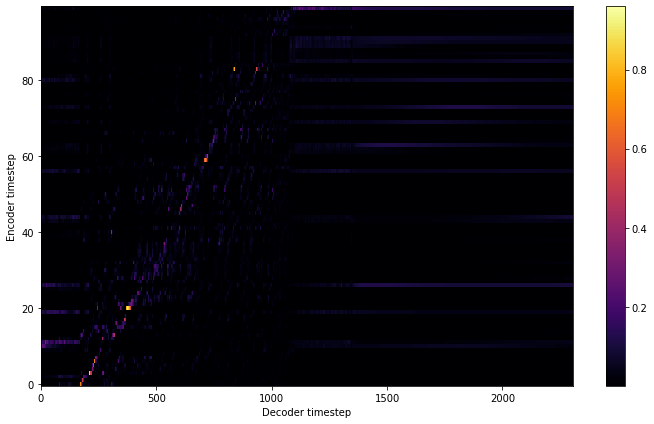

Saving model and optimizer state at iteration 17582 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 84%|███████████████████████████████████████████████████████████████            | 37/44 [22:24:40<4:13:42, 2174.66s/it]


Starting Epoch: 293 Iteration: 17582



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:55<00:00, 34.93s/it]


Epoch: 293 Validation loss 17642:  0.682995  Time: 36.7m LR: 0.000359


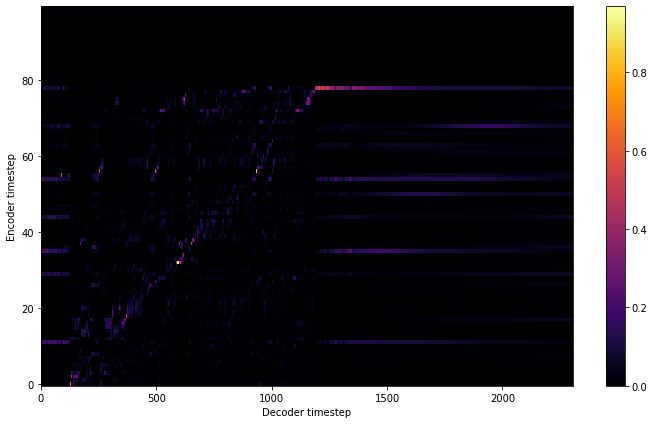

Saving model and optimizer state at iteration 17642 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 86%|████████████████████████████████████████████████████████████████▊          | 38/44 [23:01:26<3:38:25, 2184.23s/it]


Starting Epoch: 294 Iteration: 17642



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:23<00:00, 34.38s/it]


Epoch: 294 Validation loss 17702:  0.685288  Time: 36.2m LR: 0.000357


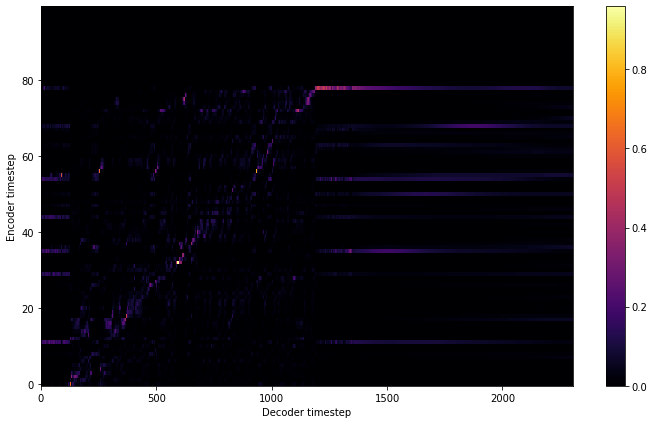

Saving model and optimizer state at iteration 17702 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 89%|██████████████████████████████████████████████████████████████████▍        | 39/44 [23:37:40<3:01:45, 2181.18s/it]


Starting Epoch: 295 Iteration: 17702



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:32<00:00, 34.54s/it]


Epoch: 295 Validation loss 17762:  0.688324  Time: 36.5m LR: 0.000354


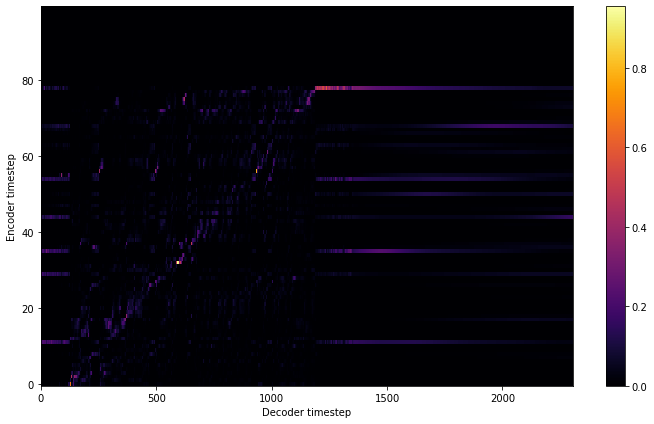

Saving model and optimizer state at iteration 17762 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 91%|████████████████████████████████████████████████████████████████████▏      | 40/44 [24:14:14<2:25:40, 2185.06s/it]


Starting Epoch: 296 Iteration: 17762



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:04<00:00, 34.08s/it]


Epoch: 296 Validation loss 17822:  0.690218  Time: 35.9m LR: 0.000351


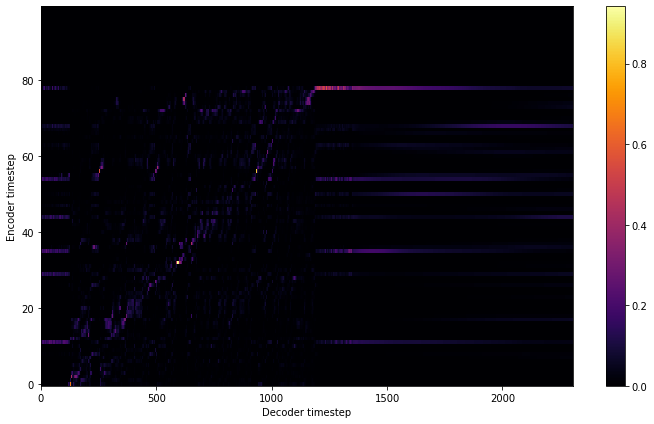

Saving model and optimizer state at iteration 17822 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 93%|█████████████████████████████████████████████████████████████████████▉     | 41/44 [24:50:10<1:48:48, 2176.31s/it]


Starting Epoch: 297 Iteration: 17822



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [33:45<00:00, 33.76s/it]


Epoch: 297 Validation loss 17882:  0.683489  Time: 35.6m LR: 0.000349


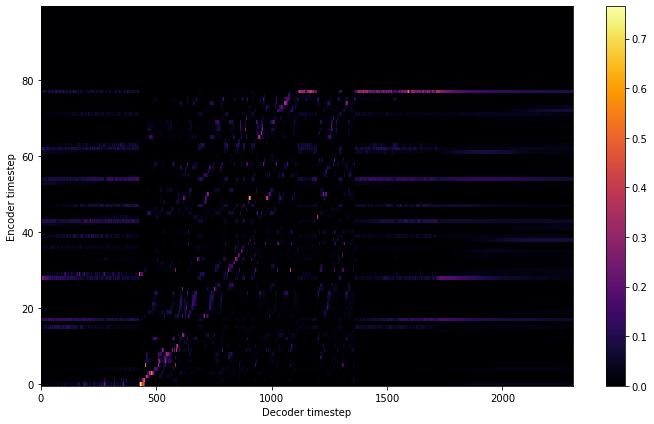

Saving model and optimizer state at iteration 17882 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 95%|███████████████████████████████████████████████████████████████████████▌   | 42/44 [25:25:47<1:12:09, 2164.59s/it]


Starting Epoch: 298 Iteration: 17882



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:14<00:00, 34.25s/it]


Epoch: 298 Validation loss 17942:  0.684028  Time: 36.0m LR: 0.000346


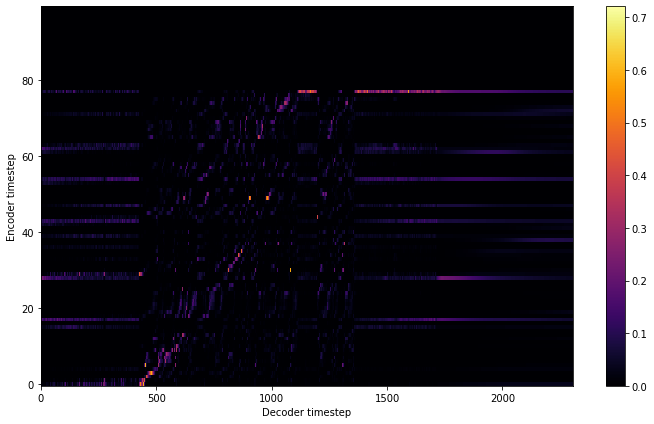

Saving model and optimizer state at iteration 17942 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


 98%|███████████████████████████████████████████████████████████████████████████▎ | 43/44 [26:01:53<36:04, 2164.77s/it]


Starting Epoch: 299 Iteration: 17942



100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [34:22<00:00, 34.38s/it]


Epoch: 299 Validation loss 18002:  0.683946  Time: 36.2m LR: 0.000344


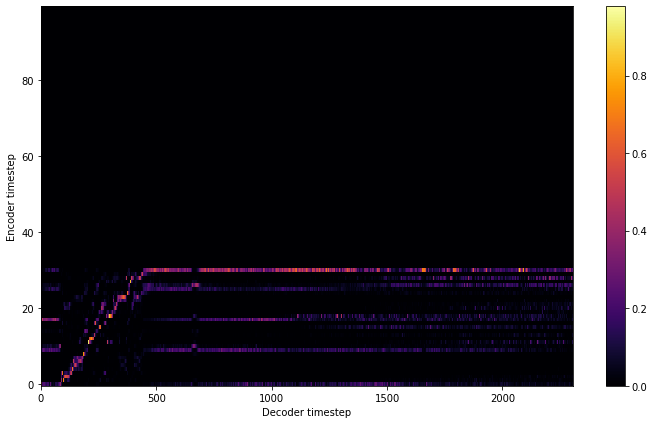

Saving model and optimizer state at iteration 18002 to G:\Research\TTA\Tam-TTS\tacotron2\colab\outdir/Tamil
Model Saved


100%|█████████████████████████████████████████████████████████████████████████████| 44/44 [26:38:06<00:00, 2179.24s/it]


In [11]:
print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
print('output_directory: ', output_directory)
print('log_directory: ', log_directory)
print("checkpoint_path: ", checkpoint_path)
print('warm_start: ', warm_start)
print('n_gpus: ',n_gpus)
print('rank: ',rank)
print('group_name: ', group_name)
print('hparams: ', hparams)
print('log_directory2: ',log_directory2)

train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus, rank, group_name, hparams, log_directory2)

In [12]:
torch.cuda.is_available()

True

In [1]:
#@markdown Config:

#@markdown Restart the code to apply any changes.

#Add new characters here.
#Universal HiFi-GAN (has some robotic noise): 1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW
Tacotron2_Model = 'G:\\Research\\TTA\\Tam-TTS\\tacotron2\\colab\\outdi\\Tamil' #'/content/drive/MyDrive/YOURMODEL'#@param {type:"string"}
TACOTRON2_ID = Tacotron2_Model
HIFIGAN_ID = "1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW"

# Check if Initilized
try:
    initilized
except NameError:
    print("Setting up, please wait.\n")
    # !pip install tqdm -q
    from tqdm.notebook import tqdm
    with tqdm(total=5, leave=False) as pbar:
        # %tensorflow_version 1.x
        import os
        from os.path import exists, join, basename, splitext
        # !pip install gdown
        git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
        project_name = splitext(basename(git_repo_url))[0]
        print(project_name)
        if not exists(project_name):
            
            print("##########", project_name)
            # clone and install
            !git clone -q --recursive {git_repo_url}
            !git clone -q --recursive https://github.com/SortAnon/hifi-gan
            # !pip install -q librosa unidecode
        pbar.update(1) # downloaded TT2 and HiFi-GAN
        import sys
        sys.path.append('hifi-gan')
        sys.path.append(project_name)
        import time
        import matplotlib
        import matplotlib.pylab as plt
        import gdown
        d = 'https://drive.google.com/uc?id='

        %matplotlib inline
        import IPython.display as ipd
        import numpy as np
        import torch
        import json
        from hparams import create_hparams
        from model import Tacotron2
        from layers import TacotronSTFT
        from audio_processing import griffin_lim
        from text import text_to_sequence
        from env import AttrDict
        from meldataset import MAX_WAV_VALUE
        from models import Generator

        pbar.update(1) # initialized Dependancies

        graph_width = 900
        graph_height = 360
        def plot_data(data, figsize=(int(graph_width/100), int(graph_height/100))):
            %matplotlib inline
            fig, axes = plt.subplots(1, len(data), figsize=figsize)
            for i in range(len(data)):
                axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                            interpolation='none', cmap='inferno')
            fig.canvas.draw()
            plt.show()

        # Setup Pronounciation Dictionary
        !gdown --id '1E12g_sREdcH5vuZb44EZYX8JjGWQ9rRp'
        thisdict = {}
        for line in reversed((open('merged.dict.txt', "r").read()).splitlines()):
            thisdict[(line.split(" ",1))[0]] = (line.split(" ",1))[1].strip()

        pbar.update(1) # Downloaded and Set up Pronounciation Dictionary

        def ARPA(text, punctuation=r"!?,.;", EOS_Token=True):
            out = ''
            for word_ in text.split(" "):
                word=word_; end_chars = ''
                while any(elem in word for elem in punctuation) and len(word) > 1:
                    if word[-1] in punctuation: end_chars = word[-1] + end_chars; word = word[:-1]
                    else: break
                try:
                    word_arpa = thisdict[word.upper()]
                    word = "{" + str(word_arpa) + "}"
                except KeyError: pass
                out = (out + " " + word + end_chars).strip()
            if EOS_Token and out[-1] != ";": out += ";"
            return out

        def get_hifigan(MODEL_ID):
            # Download HiFi-GAN
            hifigan_pretrained_model = 'hifimodel'
            gdown.download(d+MODEL_ID, hifigan_pretrained_model, quiet=False)
            if not exists(hifigan_pretrained_model):
                raise Exception("HiFI-GAN model failed to download!")

            # Load HiFi-GAN
            conf = os.path.join("hifi-gan", "config_v1.json")
            with open(conf) as f:
                json_config = json.loads(f.read())
            h = AttrDict(json_config)
            torch.manual_seed(h.seed)
            hifigan = Generator(h).to(torch.device("cuda"))
            state_dict_g = torch.load(hifigan_pretrained_model, map_location=torch.device("cuda"))
            hifigan.load_state_dict(state_dict_g["generator"])
            hifigan.eval()
            hifigan.remove_weight_norm()
            return hifigan, h

        hifigan, h = get_hifigan(HIFIGAN_ID)
        pbar.update(1) # Downloaded and Set up HiFi-GAN

        def has_MMI(STATE_DICT):
            return any(True for x in STATE_DICT.keys() if "mi." in x)

        def get_Tactron2(MODEL_ID):
            # Download Tacotron2
            tacotron2_pretrained_model = TACOTRON2_ID
            if not exists(tacotron2_pretrained_model):
                raise Exception("Tacotron2 model failed to download!")
            # Load Tacotron2 and Config
            hparams = create_hparams()
            hparams.sampling_rate = 22050
            hparams.max_decoder_steps = 3000 # Max Duration
            hparams.gate_threshold = 0.25 # Model must be 25% sure the clip is over before ending generation
            model = Tacotron2(hparams)
            state_dict = torch.load(tacotron2_pretrained_model)['state_dict']
            if has_MMI(state_dict):
                raise Exception("ERROR: This notebook does not currently support MMI models.")
            model.load_state_dict(state_dict)
            _ = model.cuda().eval().half()
            return model, hparams

        model, hparams = get_Tactron2(TACOTRON2_ID)
        previous_tt2_id = TACOTRON2_ID

        pbar.update(1) # Downloaded and Set up Tacotron2

        # Extra Info
        def end_to_end_infer(text, pronounciation_dictionary, show_graphs):
            for i in [x for x in text.split("\n") if len(x)]:
                if not pronounciation_dictionary:
                    if i[-1] != ";": i=i+";" 
                else: i = ARPA(i)
                with torch.no_grad(): # save VRAM by not including gradients
                    sequence = np.array(text_to_sequence(i, ['english_cleaners']))[None, :]
                    sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
                    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
                    if show_graphs:
                        plot_data((mel_outputs_postnet.float().data.cpu().numpy()[0],
                                alignments.float().data.cpu().numpy()[0].T))
                    y_g_hat = hifigan(mel_outputs_postnet.float())
                    audio = y_g_hat.squeeze()
                    audio = audio * MAX_WAV_VALUE
                    print("")
                    ipd.display(ipd.Audio(audio.cpu().numpy().astype("int16"), rate=hparams.sampling_rate))
    from IPython.display import clear_output
    clear_output()
    initilized = "Ready"

if previous_tt2_id != TACOTRON2_ID:
    print("Updating Models")
    model, hparams = get_Tactron2(TACOTRON2_ID)
    hifigan, h = get_hifigan(HIFIGAN_ID)
    previous_tt2_id = TACOTRON2_ID

pronounciation_dictionary = False #@param {type:"boolean"}
# disables automatic ARPAbet conversion, useful for inputting your own ARPAbet pronounciations or just for testing
show_graphs = True #@param {type:"boolean"}
max_duration = 25 #this does nothing
model.decoder.max_decoder_steps = 1000 #@param {type:"integer"}
stop_threshold = 0.324 #@param {type:"number"}
model.decoder.gate_threshold = stop_threshold

#@markdown ---

print(f"Current Config:\npronounciation_dictionary: {pronounciation_dictionary}\nshow_graphs: {show_graphs}\nmax_duration (in seconds): {max_duration}\nstop_threshold: {stop_threshold}\n\n")

time.sleep(1)
print("Enter/Paste your text.")
contents = []
while True:
    try:
        print("-"*50)
        line = input()
        if line == "":
            continue
        end_to_end_infer(line, pronounciation_dictionary, show_graphs)
    except EOFError:
        break
    except KeyboardInterrupt:
        print("Stopping...")
        break

Setting up, please wait.



  0%|          | 0/5 [00:00<?, ?it/s]

tacotron2


g:\research\tta\myvenv\lib\site-packages\gdown\cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id='1E12g_sREdcH5vuZb44EZYX8JjGWQ9rRp' 



Access denied with the following error:


FileNotFoundError: [Errno 2] No such file or directory: 'merged.dict.txt'